In [1]:
from typing import List
import torch
import pickle
import math
from collections import defaultdict, Counter
import numpy as np
from tqdm.auto import tqdm
import re
from matplotlib import pyplot as plt
from scipy.special import softmax

# будем использовать mpire для ускорения
# на некоторых системах есть проблема с кол-вом открываемвых
# файловы дескрипторов, поэтому разрешим нашему процессу
# создавать их в большЕм количестве
from mpire import WorkerPool
import resource
soft, hard = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (hard, hard))

/Users/max/.conda/envs/hw9/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TEST_CTC_DATASET_PATH = './test_data.pt'
VOCAB_PKL_PATH = './vocab.pkl'

In [3]:
dataset = torch.load(TEST_CTC_DATASET_PATH)
with open(VOCAB_PKL_PATH, 'rb') as fin:
    vocab_dict = pickle.load(fin)

In [4]:
vocab_dict

{0: '<pad>',
 1: '<s>',
 2: '</s>',
 3: '<unk>',
 4: '|',
 5: '-',
 6: 'ё',
 7: 'а',
 8: 'б',
 9: 'в',
 10: 'г',
 11: 'д',
 12: 'е',
 13: 'ж',
 14: 'з',
 15: 'и',
 16: 'й',
 17: 'к',
 18: 'л',
 19: 'м',
 20: 'н',
 21: 'о',
 22: 'п',
 23: 'р',
 24: 'с',
 25: 'т',
 26: 'у',
 27: 'ф',
 28: 'х',
 29: 'ц',
 30: 'ч',
 31: 'ш',
 32: 'щ',
 33: 'ъ',
 34: 'ы',
 35: 'ь',
 36: 'э',
 37: 'ю',
 38: 'я'}

In [5]:
vocab_dict[0] = '^' # <pad>
vocab_dict[1] = '<' # <s>
vocab_dict[2] = '>' # </s>
vocab_dict[3] = '#' # <unk>
vocab_dict[4] = ' ' # '|'

In [6]:
vocab_dict

{0: '^',
 1: '<',
 2: '>',
 3: '#',
 4: ' ',
 5: '-',
 6: 'ё',
 7: 'а',
 8: 'б',
 9: 'в',
 10: 'г',
 11: 'д',
 12: 'е',
 13: 'ж',
 14: 'з',
 15: 'и',
 16: 'й',
 17: 'к',
 18: 'л',
 19: 'м',
 20: 'н',
 21: 'о',
 22: 'п',
 23: 'р',
 24: 'с',
 25: 'т',
 26: 'у',
 27: 'ф',
 28: 'х',
 29: 'ц',
 30: 'ч',
 31: 'ш',
 32: 'щ',
 33: 'ъ',
 34: 'ы',
 35: 'ь',
 36: 'э',
 37: 'ю',
 38: 'я'}

In [7]:
for i in range(5):
    print(dataset[i][1])
    print()

к сожалению эти предложения не нашли отражения в тексте

если не будет возражений я буду считать что ассамблея согласна с этим предложением

новошахтинск милый город

мы особенно рады отметить что число скрывающихся от правосудия лиц уменьшилось

контроллер



# Часть 1. Метрики.

In [51]:
# поможем себе с расстоянием Левенштейна
import Levenshtein

# Будем использовать эту функцию для нормализации текстов перед замером CER / WER
ALLOWED_SYMBOLS = re.compile(r"(^[a-zа-я\s]+$)")
def normalize_text(text: str) -> str:
    """
    В датасетах, иногда встречается '-', 'ё', апострофы и большие буквы. А мы хотим, чтобы:
        WER("Ростов-на-дону", "ростов на дону") == 0
        WER("It's", "it s") == 0
        WER("ёлки палки", "елки палки") == 0
    Поэтому заменяем в target'ах 'ё' на 'е', а '-' на ' ' и т. д.
    Кроме того на всякий случай удаляем лишние пробелы.
    И проверяем что в получившейся строке только допустимые символы.
    """
    assert isinstance(text, str)
    text = text.lower().strip().replace("ё", "е")
    text = re.sub(r"\W+", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = text.strip().split(" ")
    text = " ".join(word for word in text if len(word) > 0)
    assert (text == "") or ALLOWED_SYMBOLS.match(text)
    return text

def my_wer(ground_truth: str, predicted: str) -> float:
    text_1 = ground_truth.split()
    text_2 = predicted.split()
    return Levenshtein.distance(text_1, text_2)

def my_cer(ground_truth: str, predicted: str) -> float:
    text_1 = list(ground_truth)
    text_2 = list(predicted)
    return Levenshtein.distance(text_1, text_2)

# Функции для расчета relative CER / WER
# В функции нужно подавать строки обработанные методом normalize_text
def relative_cer(ground_truth: str, predicted: str) -> float:
    assert isinstance(ground_truth, str)
    assert isinstance(predicted, str)
    return min(1., my_cer(ground_truth, predicted) / (len(ground_truth) + 1e-10))

def relative_wer(ground_truth: str, predicted: str) -> float:
    assert isinstance(ground_truth, str)
    assert isinstance(predicted, str)
    gt_len = ground_truth.count(" ") + 1
    return min(1., my_wer(ground_truth, predicted) / (gt_len + 1e-10))

# Функции для расчета ORACLE relative CER / WER - тут мы выбираем лучшую гипотезу из beam'a
# В функции нужно подавать строки обработанные методом normalize_text
def oracle_relative_cer(ground_truth: str, predicted: List[str]) -> float:
    return min(relative_cer(ground_truth, hypo) for hypo in predicted)

def oracle_relative_wer(ground_truth: str, predicted: List[str]) -> float:
    return min(relative_wer(ground_truth, hypo) for hypo in predicted)

In [52]:
# Тесты для проверки правильности реализации cer/wer 
assert(my_cer(normalize_text("алёнка родила девчёнку"), normalize_text("аленка радила девченку Инну")) == 6)
assert(my_wer(normalize_text("алёнка родила девчёнку"), normalize_text("аленка радила девченку Инну")) == 2)

assert(my_cer(normalize_text(""), normalize_text("")) == 0)
assert(my_wer(normalize_text(""), normalize_text("")) == 0)

assert(my_cer(normalize_text("Ростов-на-дону"), normalize_text("ростов на дону")) == 0)
assert(my_wer(normalize_text("Ростов-на-дону"), normalize_text("ростов на дону")) == 0)

assert(my_cer(normalize_text("It's"), normalize_text("it s")) == 0)
assert(my_wer(normalize_text("It's"), normalize_text("it s")) == 0)

# Часть 2. CTC декодинг.

In [53]:
class CTCDecoder:

    def __init__(self, vocab_dict):
        self.vocab = vocab_dict

        # Id специальных токенов в словаре
        self.blank_id = 0
        self.bos_id = 1
        self.eos_id = 2
        self.unk_id = 3
        self.word_sep_id = 4
        # word_sep_id должен быть заменен на пробел при декодировании
        # и не забудьте удалить пробелы в конце строки!

    def argmax_decode(self, ctc_logits: torch.tensor) -> str:
        '''
        ctc_logits - ctc-матрица логитов размерности [TIME, VOCAB]
        '''
        ctc = ctc_logits.numpy()
        TIME = ctc.shape[0]
        prefix = self.vocab[1]
        for time in range(1, TIME):
            ind_max = np.argmax(ctc[time])
            if prefix[-1] != self.vocab[ind_max]:
                prefix += self.vocab[ind_max]

        result_string = ''
        vocab_list = [val for key, val in self.vocab.items()]
        for symbol in prefix:
            if symbol not in vocab_list[0:4]:
                result_string += symbol
        return normalize_text(result_string)

    def beam_search_decode(self, ctc_logits: torch.tensor, beam_size: int=16) -> List[str]:
        '''
        ctc_logits - ctc-матрица логитов размерности [TIME, VOCAB]
        beam_size - размер бима(луча)
        '''
        ctc = ctc_logits.numpy()
        vocab = [value for key, value in self.vocab.items()]
        F = ctc.shape[1]
        ctc = np.vstack((np.zeros(F), ctc))
        T = ctc.shape[0]
        empty = ''
        Pb, Pnb = defaultdict(Counter), defaultdict(Counter)
        Pb[0][empty] = 1
        Pnb[0][empty] = 0
        A_prev = [empty]
        for t in range(1, T):
            ctc[t] = softmax(ctc[t])

            for l in A_prev:
                if len(l) > 0 and l[-1] == '>':
                    Pb[t][l] = Pb[t - 1][l]
                    Pnb[t][l] = Pnb[t - 1][l]
                    continue

                for c in vocab:
                    c_ix = vocab.index(c)
                    if c == '^':
                        Pb[t][l] += ctc[t][c_ix] * (Pb[t - 1][l] + Pnb[t - 1][l])
                    else:
                        l_plus = l + c
                        if len(l) > 0 and c == l[-1]:
                            Pnb[t][l_plus] += ctc[t][c_ix] * Pb[t - 1][l]
                            Pnb[t][l] += ctc[t][c_ix] * Pnb[t - 1][l]

                        elif len(l.replace(' ', '')) > 0 and c in (' ', '>'):
                            Pnb[t][l_plus] += ctc[t][c_ix] * (Pb[t - 1][l] + Pnb[t - 1][l])
                        else:
                            Pnb[t][l_plus] += ctc[t][c_ix] * (Pb[t - 1][l] + Pnb[t - 1][l])

                        if l_plus not in A_prev:
                            Pb[t][l_plus] += ctc[t][0] * (Pb[t - 1][l_plus] + Pnb[t - 1][l_plus])
                            Pnb[t][l_plus] += ctc[t][c_ix] * Pnb[t - 1][l_plus]


            A_next = Pb[t] + Pnb[t]
            sorter = lambda key: A_next[key]
            A_prev_new = sorted(A_next, key=sorter, reverse=True)[:beam_size]
            if len(A_prev_new) > 0:
                A_prev = A_prev_new

        full_A = []
        for val in A_prev:
            full_A.append(normalize_text(val.strip('>')))
        return full_A

In [43]:
ctc_decoder = CTCDecoder(vocab_dict)

In [44]:
ctc_decoder.beam_search_decode(dataset[1][0][0])

['если не будет возражений я буду считать что ассамблея согласна с этим предложением',
 'если не будет возражений я буду считать что ассамблее согласна с этим предложением',
 'если не будет возражений я буду считать что ассамблея согласны с этим предложением',
 'если не будет возражений я бужу считать что ассамблея согласна с этим предложением',
 'если не будет возражений я буду считать что ассамблея согласна с этим предложением',
 'если не будет возражений я будут считать что ассамблея согласна с этим предложением',
 'если не будет возражений я буду считать что ассамблея совласна с этим предложением',
 'если не будет возражений я буду считать что ассамблея согласна с этим педложением',
 'если не будет возражений я буду считать что ассамблея согласн с этим предложением',
 'если не будет возражений я буду считать что ассамблея согласна с этим предложениям',
 'если не будет возражений я буду считать что ассамблея согласна с этим предложением',
 'если не будет возражений я буду считать чт

In [45]:
ctc_decoder.argmax_decode(dataset[1][0][0])

'если не будет возражений я буду считать что ассамблея согласна с этим предложением'

## <font color='red'>Внимание!</font> Далее ВЕЗДЕ используем только relative версии рассчета CER / WER и их oracle версии.

### Argmax декодинг.

In [54]:
# Рассчитаем усредненный по всему датасету relative CER / WER для ARGMAX варианта декодирования
cer_argmax = 0
wer_argmax = 0

for i in range(len(dataset)):
    predicted = ctc_decoder.argmax_decode(dataset[i][0][0])
    ground_truth = dataset[i][1]

    cer_argmax += relative_cer(normalize_text(ground_truth), normalize_text(predicted))
    wer_argmax += relative_wer(normalize_text(ground_truth), normalize_text(predicted))

cer_argmax /= len(dataset)
wer_argmax /= len(dataset)
print(f"Mean CER in argmax decoding : {cer_argmax}")
print(f"Mean WER in argmax decoding : {wer_argmax}")

Mean CER in argmax decoding : 0.04054376192476094
Mean WER in argmax decoding : 0.1557061410929387


## Вопрос №1: Как соотносятся WER и CER в задаче ASR?

## Ответ: 
### - Ошибки в символах можно считать незначитильными (CER ~4%). WER > 15% просто потому, что слово с одним неверным символом уже будет считаться неправильным. Но в целом ошибки с небольшим процентом => результат хороший

In [55]:
# Рассчитаем усредненный по всему датасету relative CER / WER для BEAM_SEARCH варианта декодирования
# Для рассчета используем beam_size = 1 !!!
# Hint : стоит использовать mpire для ускорения
cer_bs1 = 0
wer_bs1 = 0

# Здесь должен быть ваш код, который будет оцениваться
def bs1_multi(i):
    cer_beam = 0
    wer_beam = 0
    pred = ctc_decoder.beam_search_decode(dataset[i][0][0], 1)
    truth = dataset[i][1]

    cer_beam += relative_cer(normalize_text(truth), normalize_text(pred[0]))
    wer_beam += relative_wer(normalize_text(truth), normalize_text(pred[0]))

    return cer_beam, wer_beam

with WorkerPool(n_jobs=8) as pool:
    bs1_results = pool.map(bs1_multi, range(len(dataset)), progress_bar=True)

for cer, wer in bs1_results:
    cer_bs1 += cer
    wer_bs1 += wer

cer_bs1 /= len(dataset)
wer_bs1 /= len(dataset)
print(f"CER in bs decoding : {cer_bs1}")
print(f"WER in bs decoding : {wer_bs1}")

100%|██████████| 9630/9630 [01:09<00:00, 138.98it/s]

CER in bs decoding : 0.040635285577126035
WER in bs decoding : 0.1557743465116334


In [56]:
# Проверим, что мы нигде не ошиблись в написании кода beam_search_decode
np.testing.assert_almost_equal(cer_argmax, cer_bs1, decimal=4)
np.testing.assert_almost_equal(wer_argmax, wer_bs1, decimal=4)

In [57]:
predicted = ctc_decoder.beam_search_decode(dataset[0][0][0], 4)
ground_truth = dataset[0][1]
predicted

['к сожалению эти предложения не носли отражения в тексте',
 'к сожалению эти предложения не ношли отражения в тексте',
 'к сожалению эти предложения неносли отражения в тексте',
 'к сожалению эти предложения не носли отражения в тексть']

In [58]:
# Ок, значит все хорошо и можно приступить к построению графиков
# зависимости усредненного CER / WER + oracle от beam_size.

# Для этого будем использовать beam_size = [4, 8, 16, 32].
# Заполним словарик усредненных по датасету relative wer / cer наиболее вероятной гипотезы - top1_wer, top1_cer.
# Так же добавим в словарик relative oracle wer / cer - oracle_wer, oracle_cer
graph_results = {'oracle_wer':[], 'oracle_cer':[], 'top1_wer':[], 'top1_cer': []}
beam_sizes = [4, 8, 16, 32]
for beam_size in beam_sizes:
    top1_wer, top1_cer, oracle_wer, oracle_cer = 0, 0, 0, 0

    def multi_for(i):
        t_wer, t_cer, o_wer, o_cer = 0, 0, 0, 0
        predicted = ctc_decoder.beam_search_decode(dataset[i][0][0], beam_size)
        ground_truth = dataset[i][1]
        t_cer += relative_cer(normalize_text(ground_truth), normalize_text(predicted[0]))
        t_wer += relative_wer(normalize_text(ground_truth), normalize_text(predicted[0]))
        o_cer += oracle_relative_cer(normalize_text(ground_truth), predicted)
        o_wer += oracle_relative_wer(normalize_text(ground_truth), predicted)

        return t_wer, t_cer, o_wer, o_cer
    
    with WorkerPool(n_jobs=8) as pool:
        results = pool.map(multi_for, range(len(dataset)), progress_bar=True)

    for t_wer, t_cer, o_wer, o_cer in results:
        top1_wer += t_wer
        top1_cer += t_cer
        oracle_wer += o_wer
        oracle_cer += o_cer

    top1_cer /= len(dataset)
    top1_wer /= len(dataset)
    oracle_cer /= len(dataset)
    oracle_wer /= len(dataset)

    graph_results['top1_cer'].append(top1_cer)
    graph_results['top1_wer'].append(top1_wer)
    graph_results['oracle_cer'].append(oracle_cer)
    graph_results['oracle_wer'].append(oracle_wer)

100%|██████████| 9630/9630 [35:39<00:00,  4.50it/s] 


In [59]:
graph_results

{'oracle_wer': [0.12018958801474909,
  0.10541525049145312,
  0.0949981485558182,
  0.08639950132799659],
 'oracle_cer': [0.03176201735811956,
  0.028525680932826706,
  0.025974935161853854,
  0.023995970166365167],
 'top1_wer': [0.1556477320392313,
  0.15560639112561694,
  0.1556070567804882,
  0.15561504463894327],
 'top1_cer': [0.04058551124104919,
  0.04058949516059675,
  0.040585985699097674,
  0.04058393628703796]}

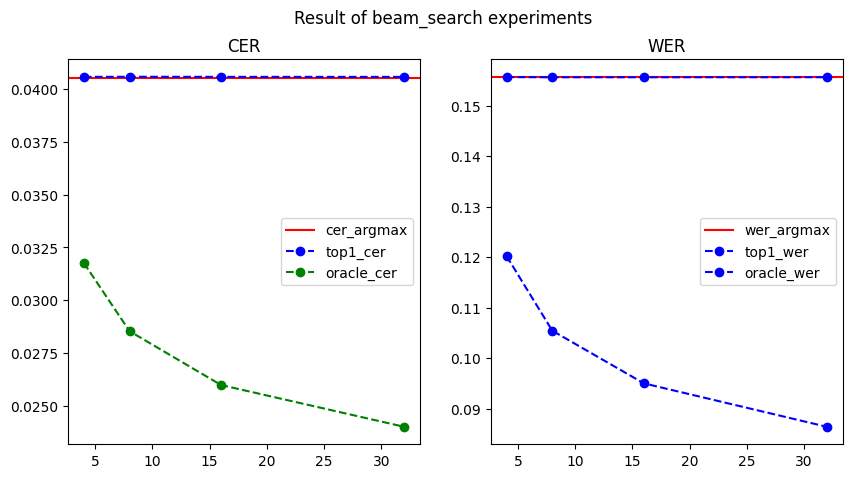

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Result of beam_search experiments')


axs[0].axhline(y = cer_argmax, color = 'r', linestyle = '-', label='cer_argmax')
axs[0].plot(beam_sizes, graph_results['top1_cer'], '--bo', label='top1_cer') 
axs[0].plot(beam_sizes, graph_results['oracle_cer'], '--go', label='oracle_cer')
axs[0].set_title('CER')
axs[0].legend()

axs[1].axhline(y = wer_argmax, color = 'r', linestyle = '-', label='wer_argmax')
axs[1].plot(beam_sizes, graph_results['top1_wer'], '--bo', label='top1_wer')
axs[1].plot(beam_sizes, graph_results['oracle_wer'], '--bo', label='oracle_wer')
axs[1].set_title('WER')
axs[1].legend()

## Вопрос №2: 
## - Сделайте выводы относительно поведения CER / WER при увеличении размера beam_size? 
## - Как соотносятся значения relative CER / WER и ORACLE варианты в beam_search ? 
## - Почему они так соотносятся ? 
## - Как можно улучшить beam search ?

## Ответ: 
### - По мере увеличения beam_size relative CER и relative WER почти не изменяются - стагнируют.
### - Однако oracle WER и oracle CER при увеличении beam_size становятся все меньше и меньше.
### - Так происходит, поскольку relative версия берет наиболее вероятную гипотезу и использует.
### - Oracle же берет топ самых вероятных гипотез и выбирает ту, при которой ошибка будет минимальна. Это и делает результат всё лучше и лучше.